# Calculating the gradient of line widths

One thing that Trey suggested was that as gas flows into the spines, there is already gas there, which could increase the pressure and density. This would naturally increase the line width because of the collisional broadening. Obviously the natural broadening would stay the same regardless of how much gas there is. The doppler broadening changes depending on the line of sight velocity dispersion. As the velocity dispersion along the line of sight increases, the doppler broadening would increase. And the collisional broadening would also increase as the pressure increases because the number of collisions increases which makes the wavefunctions discontinuous, thereby broadening the lines. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.io
from astropy.io import fits
import pandas as pd
import matplotlib as mpl
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy import units as u
import pickle
import math
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from tqdm import tqdm
from astropy.stats import sigma_clip

import os

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
path = 'v1_sigm_post.fits'
disp_cube = fits.open(path)
disp_data = disp_cube[0].data
disp_header = disp_cube[0].header
print(disp_header)

wcs_disp = wcs.WCS(disp_header)

print(wcs_disp)
print(disp_data.shape)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                 2200                                                  NAXIS2  =                  800                                                  NAXIS3  =                  199                                                  CDELT1  =      -0.001666666707                                                  CDELT2  =       0.001666666707                                                  CRPIX1  =               1100.0                                                  CRPIX2  =               9785.0                                                  CRVAL1  =        170.233333333                                                  CRVAL2  =                  0.0                                                  CTYPE1  = 'GLON-SFL'                    

WCS Keywords

Number of WCS axes: 3
CTYPE : 'GLON-SFL' 'GLAT-SFL' 'v' 
CRVAL : np.float64(170.233333333) np.float64(0.0) np.float64(4.1100502434622) 
CRPIX : np.float64(1100.0) np.float64(9785.0) np.float64(0.0) 
PC1_1 PC1_2 PC1_3  : np.float64(1.0) np.float64(0.0) np.float64(0.0) 
PC2_1 PC2_2 PC2_3  : np.float64(0.0) np.float64(1.0) np.float64(0.0) 
PC3_1 PC3_2 PC3_3  : np.float64(0.0) np.float64(0.0) np.float64(1.0) 
CDELT : np.float64(-0.001666666707) np.float64(0.001666666707) np.float64(0.020100486924401) 
NAXIS : 2200  800
(800, 2200)
6.441706726692667


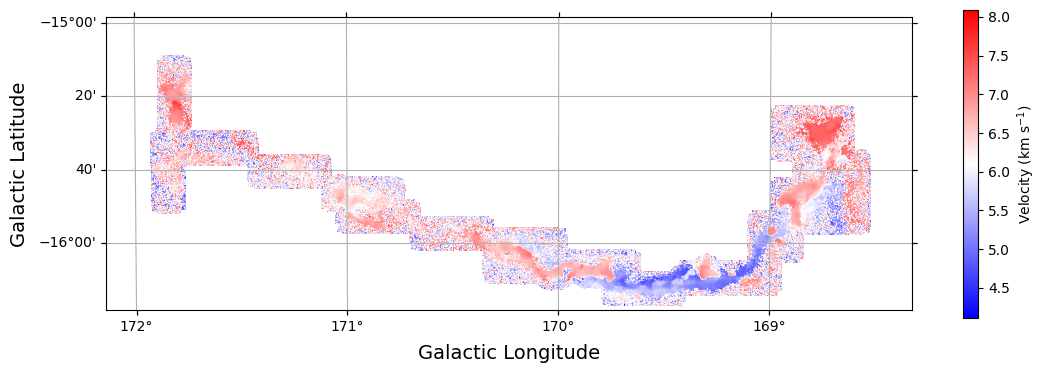

In [33]:
path = 'velocity_grid.fits'
vel_cube = fits.open(path)
vel_data = vel_cube[0].data
vel_header = vel_cube[0].header
#print(header)

wcs_vel = wcs.WCS(vel_header)

print(wcs_vel)
print(vel_data.shape)

print(vel_data[272, 1890])

plt.figure(figsize = [13, 4])
plt.subplot(projection = wcs_vel, slices=('x', 'y', 0))
plt.imshow(vel_data, cmap= 'bwr')
plt.xlabel('Galactic Longitude', fontsize = 14)
plt.ylabel('Galactic Latitude', fontsize = 14)
plt.colorbar(label = r'Velocity (km s$^{-1}$)')
plt.grid()
plt.savefig('ml_velocity_map.png', transparent=True, bbox_inches = 'tight')

In [30]:
path = 'L1495-B218_NH3_11.fits'
cube_11 = fits.open(path)
data_11 = cube_11[0].data
data_11 = np.squeeze(data_11)
header_11 = cube_11[0].header

wcs_11 = wcs.WCS(header_11)

print(wcs_11)
print(data_11.shape)

WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SFL' 'DEC--SFL' 'FREQ' 'STOKES' 
CRVAL : np.float64(170.233333333) np.float64(0.0) np.float64(23696849372.9) np.float64(1.0) 
CRPIX : np.float64(1100.0) np.float64(9785.0) np.float64(1.0) np.float64(1.0) 
NAXIS : 2200  800  1000  1
(1000, 800, 2200)


In [33]:
freq_start = header_11["CRVAL3"]
freq_inc = header_11["CDELT3"]

freq_channels = np.arange(header_11["NAXIS3"])

#define velocity as km/s blocks
frequency = freq_start + (freq_inc * freq_channels)
i_frequency = header_11["RESTFREQ"]

velocity = (3E8 * ((i_frequency - frequency)/i_frequency))/1000
velocity = np.array(velocity, dtype = float)

disp_start = disp_header["CRVAL3"]
disp_inc = disp_header["CDELT3"]

disp_channels = np.arange(disp_header["NAXIS3"])

#define velocity as km/s blocks
dispersion = disp_start + (disp_inc * disp_channels)

## Now let's apply the same integrated intensity mask to the velocity dispersion

In [34]:
import itertools 
from itertools import filterfalse 

frequency_offsets_MHz = [-1.568487, -1.526950, -0.623306, -0.590338, -0.580921, -0.036536, -0.025538, -0.024394, -0.014977, 0.005848, 
                         0.010515, 0.016847, 0.019932, 0.571792, 0.582790, 0.617700, 1.534050, 1.545049]
central_frequency_MHz = 23694.495487

velocity_offsets = [3E8 * x / central_frequency_MHz / 1000 for x in frequency_offsets_MHz]
velocity_offsets = np.array(velocity_offsets, dtype = float)
#print(velocity_offsets)

integrated_intensity = []
root_mean_sq = []
for i in tqdm(range(800)):
    row_II = []
    row_RMS = []
    for j in range(2200):
        max_velocity = vel_data[i, j]
        if math.isnan(max_velocity):
            row_II.append(max_velocity)
            row_RMS.append(max_velocity)
        else:
            ammonia_data = data_11[:, i, j]
            vel_dispersion = dispersion[list(disp_data[:, i, j]).index(np.max(disp_data[:, i, j]))]
            
            l_bound_1 = max_velocity + velocity_offsets[0] - (3 * vel_dispersion)
            l_bound_1 = list(np.abs(velocity - l_bound_1)).index(np.min(np.abs(velocity - l_bound_1)))
            r_bound_1 = max_velocity + velocity_offsets[1] + (3 * vel_dispersion)
            r_bound_1 = list(np.abs(velocity - r_bound_1)).index(np.min(np.abs(velocity - r_bound_1)))

            sum_1 = np.sum(ammonia_data[l_bound_1 : r_bound_1+1]) * (velocity[1] - velocity[0])

            l_bound_2 = max_velocity + velocity_offsets[2] - (3 * vel_dispersion)
            l_bound_2 = list(np.abs(velocity - l_bound_2)).index(np.min(np.abs(velocity - l_bound_2)))
            r_bound_2 = max_velocity + velocity_offsets[4] + (3 * vel_dispersion)
            r_bound_2 = list(np.abs(velocity - r_bound_2)).index(np.min(np.abs(velocity - r_bound_2)))

            sum_2 = np.sum(ammonia_data[l_bound_2 : r_bound_2+1]) * (velocity[1] - velocity[0])
            
            l_bound_3 = max_velocity + velocity_offsets[5] - (3 * vel_dispersion)
            l_bound_3 = list(np.abs(velocity - l_bound_3)).index(np.min(np.abs(velocity - l_bound_3)))
            r_bound_3 = max_velocity + velocity_offsets[12] + (3 * vel_dispersion)
            r_bound_3 = list(np.abs(velocity - r_bound_3)).index(np.min(np.abs(velocity - r_bound_3)))

            sum_3 = np.sum(ammonia_data[l_bound_3 : r_bound_3+1]) * (velocity[1] - velocity[0])

            l_bound_4 = max_velocity + velocity_offsets[13] - (3 * vel_dispersion)
            l_bound_4 = list(np.abs(velocity - l_bound_4)).index(np.min(np.abs(velocity - l_bound_4)))
            r_bound_4 = max_velocity + velocity_offsets[15] + (3 * vel_dispersion)
            r_bound_4 = list(np.abs(velocity - r_bound_4)).index(np.min(np.abs(velocity - r_bound_4)))

            sum_4 = np.sum(ammonia_data[l_bound_4 : r_bound_4+1]) * (velocity[1] - velocity[0])

            l_bound_5 = max_velocity + velocity_offsets[16] - (3 * vel_dispersion)
            l_bound_5 = list(np.abs(velocity - l_bound_5)).index(np.min(np.abs(velocity - l_bound_5)))
            r_bound_5 = max_velocity + velocity_offsets[17] + (3 * vel_dispersion)
            r_bound_5 = list(np.abs(velocity - r_bound_5)).index(np.min(np.abs(velocity - r_bound_5)))

            sum_5 = np.sum(ammonia_data[l_bound_5 : r_bound_5+1]) * (velocity[1] - velocity[0])

            integrated_int = sum_1 + sum_2 + sum_3 + sum_4 + sum_5

            res = list(filterfalse(np.arange(l_bound_1 - 5, r_bound_1 + 6).__contains__,
                       np.arange(0, 1000)))
            res = list(filterfalse(np.arange(l_bound_2 - 5, r_bound_2 + 6).__contains__,
                       res))
            res = list(filterfalse(np.arange(l_bound_3 - 5, r_bound_3 + 6).__contains__,
                       res))
            res = list(filterfalse(np.arange(l_bound_4 - 5, r_bound_4 + 6).__contains__,
                       res))
            res = list(filterfalse(np.arange(l_bound_5 - 5, r_bound_5 + 6).__contains__,
                       res))
            rms = np.sqrt(np.sum([x**2 for x in ammonia_data[res[50:-50]]])/len(res[50:-50]))

            row_II.append(integrated_int)
            row_RMS.append(rms)
    integrated_intensity.append(row_II)
    root_mean_sq.append(row_RMS)

100%|█████████████████████████████████████████| 800/800 [35:13<00:00,  2.64s/it]


In [35]:
chan_spacing = velocity[1] - velocity[0]

error_ii = []
for i in tqdm(range(800)):
    row_IIE = []
    for j in range(2200):
        max_velocity = vel_data[i, j]
        if math.isnan(max_velocity):
            row_IIE.append(max_velocity)
        else:
            vel_dispersion = dispersion[list(disp_data[:, i, j]).index(np.max(disp_data[:, i, j]))]
            rms = root_mean_sq[i][j]
            
            l_bound_1 = max_velocity + velocity_offsets[0] - (3 * vel_dispersion)
            l_bound_1 = list(np.abs(velocity - l_bound_1)).index(np.min(np.abs(velocity - l_bound_1)))
            r_bound_1 = max_velocity + velocity_offsets[1] + (3 * vel_dispersion)
            r_bound_1 = list(np.abs(velocity - r_bound_1)).index(np.min(np.abs(velocity - r_bound_1)))

            l_bound_2 = max_velocity + velocity_offsets[2] - (3 * vel_dispersion)
            l_bound_2 = list(np.abs(velocity - l_bound_2)).index(np.min(np.abs(velocity - l_bound_2)))
            r_bound_2 = max_velocity + velocity_offsets[4] + (3 * vel_dispersion)
            r_bound_2 = list(np.abs(velocity - r_bound_2)).index(np.min(np.abs(velocity - r_bound_2)))
            
            l_bound_3 = max_velocity + velocity_offsets[5] - (3 * vel_dispersion)
            l_bound_3 = list(np.abs(velocity - l_bound_3)).index(np.min(np.abs(velocity - l_bound_3)))
            r_bound_3 = max_velocity + velocity_offsets[12] + (3 * vel_dispersion)
            r_bound_3 = list(np.abs(velocity - r_bound_3)).index(np.min(np.abs(velocity - r_bound_3)))

            l_bound_4 = max_velocity + velocity_offsets[13] - (3 * vel_dispersion)
            l_bound_4 = list(np.abs(velocity - l_bound_4)).index(np.min(np.abs(velocity - l_bound_4)))
            r_bound_4 = max_velocity + velocity_offsets[15] + (3 * vel_dispersion)
            r_bound_4 = list(np.abs(velocity - r_bound_4)).index(np.min(np.abs(velocity - r_bound_4)))

            l_bound_5 = max_velocity + velocity_offsets[16] - (3 * vel_dispersion)
            l_bound_5 = list(np.abs(velocity - l_bound_5)).index(np.min(np.abs(velocity - l_bound_5)))
            r_bound_5 = max_velocity + velocity_offsets[17] + (3 * vel_dispersion)
            r_bound_5 = list(np.abs(velocity - r_bound_5)).index(np.min(np.abs(velocity - r_bound_5)))

            vel_interval = ((velocity[r_bound_5] - velocity[l_bound_5]) + (velocity[r_bound_4] - velocity[l_bound_4]) + 
                            (velocity[r_bound_3] - velocity[l_bound_3]) + (velocity[r_bound_2] - velocity[l_bound_2]) + 
                            (velocity[r_bound_1] - velocity[l_bound_1]))

            error = rms * np.sqrt(chan_spacing * vel_interval)

            row_IIE.append(error)
    error_ii.append(row_IIE)

100%|█████████████████████████████████████████| 800/800 [01:26<00:00,  9.20it/s]


In [6]:
velocity_dispersion = []
for i in tqdm(range(800)):
    row_disp = []
    for j in range(2200):
        max_dispersion = np.max(disp_data[:, i, j])
        if math.isnan(max_dispersion):
            row_disp.append(max_dispersion)
        else:
            row_disp.append(max_dispersion)
    velocity_dispersion.append(row_disp)

100%|████████████████████████████████████████| 800/800 [00:03<00:00, 262.14it/s]


In [38]:
masked_dispersion = []
for i in tqdm(range(800)):
    row_masked = []
    for j in range(2200):
        max_disp = np.max(disp_data[:, i, j])
        if math.isnan(max_disp):
            row_masked.append(max_disp)
        else:
            error = error_ii[i][j]
            intensity = integrated_intensity[i][j]

            if intensity >= 3*error:
                row_masked.append(max_disp)
            else:
                row_masked.append(integrated_intensity[50][100])

    masked_dispersion.append(row_masked)

100%|████████████████████████████████████████| 800/800 [00:03<00:00, 265.86it/s]


0.0085642915


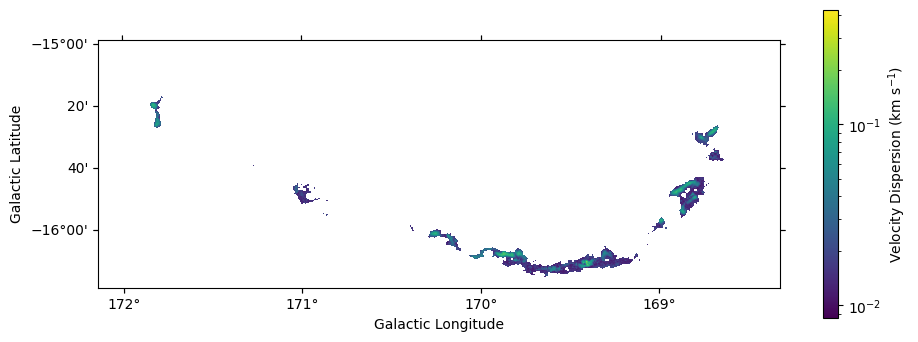

In [103]:
plt.figure(figsize = [11, 4])
plt.subplot(projection = wcs_disp, slices=('x', 'y', 0))
plt.imshow(masked_dispersion, norm = LogNorm())
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
plt.colorbar(label = r'Velocity Dispersion (km s$^{-1}$)')

print(np.nanmin(velocity_dispersion))

output_hdu = wcs_disp.to_fits()
output_hdu[0].data is None

output_hdu[0].data = masked_dispersion

output_hdu.writeto("masked_ML_dispersion.fits", overwrite=True)

In [3]:
path = 'masked_ML_velocity.fits'
cube = fits.open(path)
masked_vel_data = cube[0].data
header = cube[0].header

wcs_masked_vel = wcs.WCS(header)

In [4]:
path = 'masked_ML_dispersion.fits'
cube = fits.open(path)
masked_disp_data = cube[0].data
header = cube[0].header

wcs_masked_disp = wcs.WCS(header)

In [5]:
path = 'distance_transform.fits'
cube = fits.open(path)
distance_transform_data = cube[0].data
header = cube[0].header

wcs_dist_transform = wcs.WCS(header)

In [6]:
region = 'B7'
path = region + '_velocity_posterior.fits'
cube = fits.open(path)
data = cube[0].data
header = cube[0].header

wcs_subregion = wcs.WCS(header)
print(wcs_subregion)
print(data.shape)

WCS Keywords

Number of WCS axes: 3
CTYPE : 'GLON-SFL' 'GLAT-SFL' 'v' 
CRVAL : np.float64(170.233333333) np.float64(0.0) np.float64(4.1100502434622) 
CRPIX : np.float64(-780.0) np.float64(9409.0) np.float64(0.0) 
PC1_1 PC1_2 PC1_3  : np.float64(1.0) np.float64(0.0) np.float64(0.0) 
PC2_1 PC2_2 PC2_3  : np.float64(0.0) np.float64(1.0) np.float64(0.0) 
PC3_1 PC3_2 PC3_3  : np.float64(0.0) np.float64(0.0) np.float64(1.0) 
CDELT : np.float64(-0.001666666707) np.float64(0.001666666707) np.float64(0.020100486924401) 
NAXIS : 135  169  199
(199, 169, 135)


In [7]:
list_ = open("Seo_NH3_peaks.txt").read().split()
strings = list_[4:]
ra_strings = []
dec_strings = []
for i in range(39):
    ra_strings.append(strings[i*3])
    dec_strings.append(strings[i*3+1])

ra = []
dec = []
for i in range(39):
    ra_val = ra_strings[i]
    ra_value = float(ra_val[0])*15 + 15*float(ra_val[2:4])/60 + 15*float(ra_val[5:11])/3600
    ra.append(ra_value)

    dec_val = dec_strings[i]
    dec_value = float(dec_val[0:2]) + float(dec_val[3:5])/60 + float(dec_val[6:11])/3600
    dec.append(dec_value)

c = SkyCoord(ra, dec, frame='icrs', unit='deg')
galactic_coords = c.galactic

lon = np.array(galactic_coords.l*u.degree)
lat = np.array(galactic_coords.b*u.degree)

c = SkyCoord(lon, lat, frame='galactic', unit='deg')

pixels_x, pixels_y = astropy.wcs.utils.skycoord_to_pixel(c, wcs = wcs_dist_transform, origin=1)
pixels_x_vel, pixels_y_vel = astropy.wcs.utils.skycoord_to_pixel(c, wcs = wcs_subregion, origin=1)

In [8]:
longitude = [135, #B7
            249, #B216
            173, #B218
            343, #B213
            353, #B211
            169 #B10
            ]
latitude = [169, #B7
           169, #B216
           163, #B218
           127, #B213
           133, #B211
           178 #B10
           ]

if region == 'B7':
    index = 0
elif region == 'B216':
    index = 1
elif region == 'B218':
    index = 2
elif region == 'B213':
    index = 3
elif region == 'B211':
    index = 4
elif region == 'B10':
    index = 5

In [9]:
(l_min, b_min, vel), (l_max, b_max, vel) = wcs_subregion.wcs_pix2world([[0, 0, 0], [longitude[index], latitude[index], 0]], 0)

print(l_min, l_max)
print(b_min, b_max)

(l_min_pix, b_min_pix, vel), (l_max_pix, b_max_pix, vel) = wcs_disp.wcs_world2pix([[l_min, b_min, vel], [l_max, b_max, vel]], 0)

print(l_min_pix, l_max_pix)
print(b_min_pix, b_max_pix)

disp_subregion = []
for i in range(int(b_min_pix), int(b_max_pix)):
    row = []
    for j in range(int(l_min_pix), int(l_max_pix)):
        row.append(masked_dispersion[i][j])
    disp_subregion.append(row)

plt.figure(figsize = [5, 4])
ax_1 = plt.subplot(111, projection = wcs_subregion, slices=('x', 'y', 0))
im = ax_1.imshow(masked_dispersion, cmap = 'magma', vmin = np.nanmin(disp_subregion), vmax = np.nanmax(disp_subregion))
plt.scatter(pixels_x, pixels_y, s = 6, c = 'black')
ax_1.set_facecolor("grey")
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
ax_1.set(xlim=(round(l_min_pix), round(l_max_pix)), ylim=(round(b_min_pix), round(b_max_pix)))
cbar = plt.colorbar(im, label = r'Velocity (km/s) (3$\sigma$ mask)')
#ax_1.text(1360, 180, 'B213', fontsize = 16, fontweight = 'bold')
ax_1.add_patch(plt.Rectangle((round(l_min_pix) + 0, round(b_min_pix) + 0), longitude[index], latitude[index], ls="--", ec="k", fc="none"))

168.88135428017964 168.64982358061732
-15.680000379456 -15.398333705973
1879.999999999992 2015.000000000004
376.0 545.0


NameError: name 'masked_dispersion' is not defined

135 135
169 169
135 135
169 169
135 135
169 169
135 169
0.031439591794849224


/tmp/ipykernel_3189310/1605182256.py:41: RuntimeWarning: invalid value encountered in scalar divide
  proj_length = (-grad_x_spines[i][j] * grad_x_disp[i][j] + -grad_y_spines[i][j] * grad_y_disp[i][j])/((grad_x_spines[i][j])**2 + (grad_y_spines[i][j])**2)


ValueError: zero-size array to reduction operation minimum which has no identity

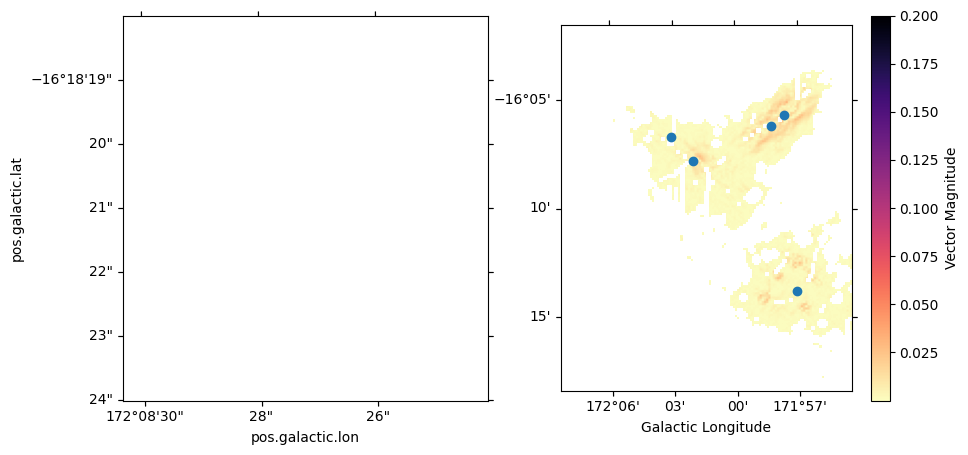

In [10]:
def divergence(scalar_field):
    gy, gx = np.gradient(scalar_field)
    print(len(gx[0]), len(gy[0]))
    return(gy, gx)

lon_length, lat_length = longitude[index], latitude[index]
lon_start, lat_start = 0, 0

subregion_spines = distance_transform_data[round(b_min_pix + lat_start):round(b_min_pix + lat_start + lat_length), round(l_min_pix + lon_start):round(l_min_pix + lon_start + lon_length)]
grad_y_spines, grad_x_spines = divergence(subregion_spines) #Flip the order because the coordinates get put in (b, l) and not (l, b)
print(len(grad_x_spines), len(grad_y_spines))

#grad_y_disp, grad_x_disp = divergence(disp_subregion)
#print(len(grad_x_disp), len(grad_y_disp))

subregion_disp = masked_disp_data[round(b_min_pix + lat_start):round(b_min_pix + lat_start + lat_length), round(l_min_pix + lon_start):round(l_min_pix + lon_start + lon_length)]
grad_y_disp, grad_x_disp = divergence(subregion_disp) #Flip the order because the coordinates get put in (b, l) and not (l, b)
print(len(grad_x_disp), len(grad_y_disp))

subregion_vel = masked_vel_data[round(b_min_pix + lat_start):round(b_min_pix + lat_start + lat_length), round(l_min_pix + lon_start):round(l_min_pix + lon_start + lon_length)]
grad_y_vel, grad_x_vel = divergence(subregion_vel) #Flip the order because the coordinates get put in (b, l) and not (l, b)
print(len(grad_x_vel), len(grad_y_vel))

x = np.arange(0, lon_length, 1)
y = np.arange(0, lat_length, 1)

X, Y = np.meshgrid(x,y)

print(len(x), len(y))

perp_grad_x = []
perp_grad_y = []
x_vals = []
y_vals = []
divergence = []
for i in range(len(y)):
    #x_values = []
    #y_values = []
    summed = []
    for j in range(len(x)):
        proj_length = (-grad_x_spines[i][j] * grad_x_disp[i][j] + -grad_y_spines[i][j] * grad_y_disp[i][j])/((grad_x_spines[i][j])**2 + (grad_y_spines[i][j])**2)
        magnitude = np.sqrt((-grad_x_spines[i][j] * proj_length)**2 + (-grad_y_spines[i][j] * proj_length)**2)

        if magnitude < 0.2:        
            perp_grad_x.append(-grad_x_spines[i][j] * proj_length)
            perp_grad_y.append(-grad_y_spines[i][j] * proj_length)

            x_vals.append(x[j])
            y_vals.append(y[i])
        
        summed.append(np.sqrt((-grad_x_spines[i][j] * proj_length)**2 + (-grad_y_spines[i][j] * proj_length)**2))
        
    #perp_grad_x.append(x_values)
    #perp_grad_y.append(y_values)
    divergence.append(summed)

print(np.nanmax(divergence))

plt.figure(figsize = [16, 5])

ax_3 = plt.subplot(133, projection = wcs_disp, slices=('x', 'y', 0))
im = ax_3.imshow(divergence, cmap = 'magma_r', vmax = 0.2)
#im = ax_1.imshow(perp_divergence, cmap = 'magma')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude', c = 'white')
ax_3.scatter(pixels_x_vel-lon_start, pixels_y_vel-lat_start)
ax_3.set(xlim=(0, longitude[index] - 0.5), ylim=(0, latitude[index] - 0.5))
#plt.quiver(x, y, grad_x_vel, grad_y_vel, color = 'black')
cbar = plt.colorbar(im, label = 'Vector Magnitude')

ax_2 = plt.subplot(132, projection = wcs_disp, slices=('x', 'y', 0))
im = ax_2.imshow(disp_subregion, cmap = 'inferno', vmin = np.nanmin(disp_subregion), vmax = np.nanmax(disp_subregion))
#im = ax_2.imshow(perp_divergence, cmap = 'magma')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude', c = 'white')
ax_2.scatter(pixels_x_vel-lon_start, pixels_y_vel-lat_start, color = 'black')
ax_2.set(xlim=(0, longitude[index] - 0.5), ylim=(0, latitude[index] - 0.5))
plt.quiver(x, y, grad_x_disp, grad_y_disp, color = 'black')
cbar = plt.colorbar(im, label = 'Velocity (km/s)')

ax_1 = plt.subplot(131, projection = wcs_disp, slices=('x', 'y', 0))
im = ax_1.imshow(subregion_spines, cmap = 'viridis_r', vmax = np.nanmax(subregion_spines))
plt.quiver(x_vals, y_vals, perp_grad_x, perp_grad_y, color = 'black')
#plt.quiver(x, y, -grad_x_spines, -grad_y_spines, color = 'black')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
cbar = plt.colorbar(im, label = 'Pixels from Spine')
#ax_1.add_patch(plt.Circle((109, 129), 1))
ax_1.scatter(pixels_x_vel-lon_start, pixels_y_vel-lat_start)
ax_1.set(xlim=(0, longitude[index] - 0.5), ylim=(0, latitude[index] - 0.5))

Text(0, 0.5, 'Fraction of Pixels')

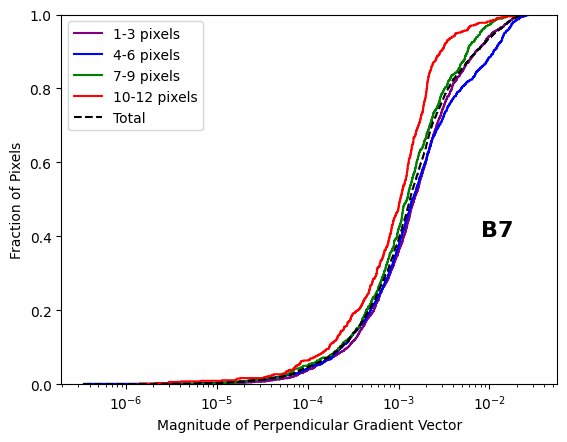

In [11]:
vec_mag_low = []
vec_mag_med = []
vec_mag_high = []
vec_mag_higher = []
total_vec_mag = []

for i in range(lon_length):
    for j in range(lat_length):
        if 1 <= subregion_spines[j][i] <= 3:
            if divergence[j][i] < 0.2:
                #dist_spine_8.append(subregion_spines[j][i])
                vec_mag_low.append(divergence[j][i])
                total_vec_mag.append(divergence[j][i])
        elif 4 <= subregion_spines[j][i] <= 6:
            if divergence[j][i] < 0.2:
                #dist_spine_7.append(subregion_spines[j][i])
                vec_mag_med.append(divergence[j][i])
                total_vec_mag.append(divergence[j][i])
        elif 7 <= subregion_spines[j][i] <= 9:
            if divergence[j][i] < 0.2:
                #dist_spine_6.append(subregion_spines[j][i])
                vec_mag_high.append(divergence[j][i])
                total_vec_mag.append(divergence[j][i])
        elif 10 <= subregion_spines[j][i] <= 12:
            if divergence[j][i] < 0.2:
                #dist_spine_5.append(subregion_spines[j][i])
                vec_mag_higher.append(divergence[j][i])
                total_vec_mag.append(divergence[j][i])

plt.ecdf(vec_mag_low, label = '1-3 pixels', color = 'purple')
plt.ecdf(vec_mag_med, label = '4-6 pixels', color = 'blue')
plt.ecdf(vec_mag_high, label = '7-9 pixels', color = 'green')
plt.ecdf(vec_mag_higher, label = '10-12 pixels', color = 'red')
plt.ecdf(total_vec_mag, label = 'Total', linestyle = 'dashed', color = 'black')

plt.xscale('log')
#plt.yscale('log')
#plt.xlim(0.003, 0.25)
#plt.ylim(-0.05, 1.05)
plt.text(0.008, 0.4, region, fontsize = 16, fontweight = 'bold')

plt.legend(loc = 'upper left')
plt.xlabel('Magnitude of Perpendicular Gradient Vector')
plt.ylabel('Fraction of Pixels')

135 135
169 169
135 135
169 169


/tmp/ipykernel_3189310/4099310348.py:56: RuntimeWarning: invalid value encountered in scalar divide
  proj_length = (par_x_spines[i][j] * grad_x_disp[i][j] + par_y_spines[i][j] * grad_y_disp[i][j])/((par_x_spines[i][j])**2 +


[(0.0, 134.5), (0.0, 168.5)]

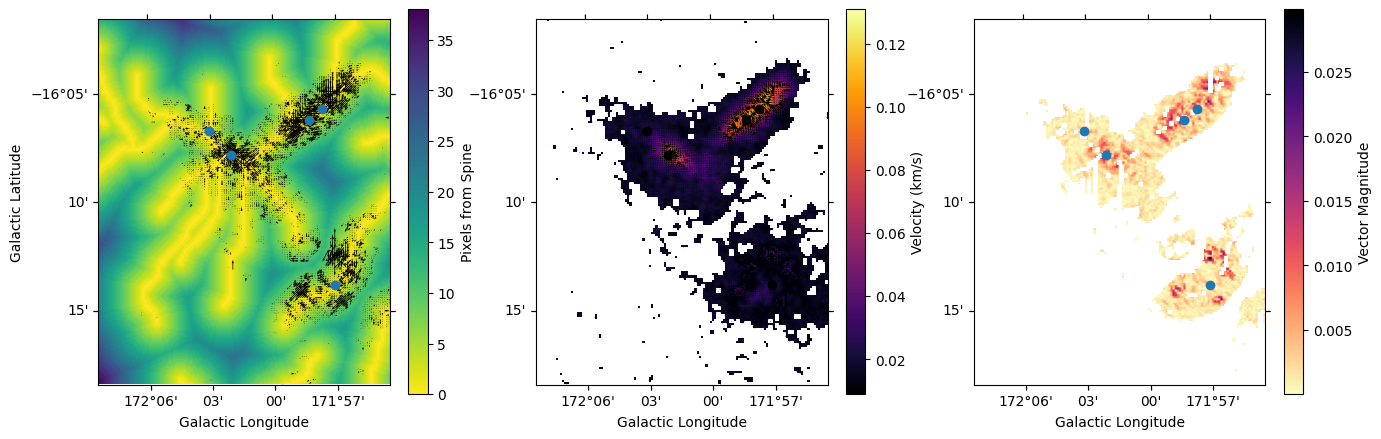

In [18]:
def divergence(scalar_field):
    gy, gx = np.gradient(scalar_field)
    print(len(gx[0]), len(gy[0]))
    return(gy, gx)

lon_length, lat_length = longitude[index], latitude[index]
lon_start, lat_start = 0, 0

subregion_spines = distance_transform_data[round(b_min_pix + lat_start):round(b_min_pix + lat_start + lat_length), round(l_min_pix + lon_start):round(l_min_pix + lon_start + lon_length)]
grad_y_spines, grad_x_spines = divergence(subregion_spines) #Flip the order because the coordinates get put in (b, l) and not (l, b)
print(len(grad_x_spines), len(grad_y_spines))

subregion_disp = masked_disp_data[round(b_min_pix + lat_start):round(b_min_pix + lat_start + lat_length), round(l_min_pix + lon_start):round(l_min_pix + lon_start + lon_length)]
grad_y_disp, grad_x_disp = divergence(subregion_disp) #Flip the order because the coordinates get put in (b, l) and not (l, b)
print(len(grad_x_disp), len(grad_y_disp))

x = np.arange(0, lon_length, 1)
y = np.arange(0, lat_length, 1)

X, Y = np.meshgrid(x,y)

x_0 = []
y_0 = []
for i in range(lat_length):
    for j in range(lon_length):
        if subregion_spines[i][j] == 0:
            x_0.append(j)
            y_0.append(i)
            #print(i, j, grad_x_spines[i][j], grad_y_spines[i][j])

par_x_spines = []
par_y_spines = []
for i in range(lat_length):
    x_place = []
    y_place = []
    for j in range(lon_length):
        #print(j, i, list(x_0).index(j), y_0[list(x_0).index(j)]) 
        #print x coord, y coord, the index of the spine in that column, the y coordinate of the spine in that column
        if subregion_spines[i][j] <= 10:
            x_place.append(float(-grad_y_spines[i][j]))
            y_place.append(float(grad_x_spines[i][j]))
        else:
            x_place.append(float(0))
            y_place.append(float(0))
    par_x_spines.append(np.array(x_place))
    par_y_spines.append(np.array(y_place))

para_grad_x = []
para_grad_y = []
x_vals = []
y_vals = []
divergence = []
for i in range(len(y)):
    summed = []
    for j in range(len(x)):
        proj_length = (par_x_spines[i][j] * grad_x_disp[i][j] + par_y_spines[i][j] * grad_y_disp[i][j])/((par_x_spines[i][j])**2 + 
                                                                                                       (par_y_spines[i][j])**2)
        magnitude = np.sqrt((par_x_spines[i][j] * proj_length)**2 + (par_y_spines[i][j] * proj_length)**2)

        if magnitude <= 0.2:
            #Do something
        
            para_grad_x.append(par_x_spines[i][j] * proj_length)
            para_grad_y.append(par_y_spines[i][j] * proj_length)

            x_vals.append(x[j])
            y_vals.append(y[i])
        
        summed.append(np.sqrt((par_x_spines[i][j] * proj_length)**2 + (par_y_spines[i][j] * proj_length)**2))
        #else:
            #summed.append(subregion_vel[0][0])
            #print(subregion_vel[0][0])
        
    divergence.append(summed)

plt.figure(figsize = [16, 5])

ax_3 = plt.subplot(133, projection = wcs_disp, slices=('x', 'y', 0))
im = ax_3.imshow(divergence, cmap = 'magma_r')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude', c = 'white')
ax_3.scatter(pixels_x_vel-lon_start, pixels_y_vel-lat_start)
ax_3.set(xlim=(0, longitude[index] - 0.5), ylim=(0, latitude[index] - 0.5))
cbar = plt.colorbar(im, label = 'Vector Magnitude')

ax_2 = plt.subplot(132, projection = wcs_disp, slices=('x', 'y', 0))
im = ax_2.imshow(subregion_disp, cmap = 'inferno', vmin = np.nanmin(subregion_disp), vmax = np.nanmax(subregion_disp))
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude', c = 'white')
ax_2.scatter(pixels_x_vel-lon_start, pixels_y_vel-lat_start, color = 'black')
ax_2.set(xlim=(0, longitude[index] - 0.5), ylim=(0, latitude[index] - 0.5))
plt.quiver(X, Y, grad_x_disp, grad_y_disp, color = 'black')
cbar = plt.colorbar(im, label = 'Velocity (km/s)')

ax_1 = plt.subplot(131, projection = wcs_disp, slices=('x', 'y', 0))
im = ax_1.imshow(subregion_spines, cmap = 'viridis_r', vmax = np.nanmax(subregion_spines))
#plt.quiver(x_vals, y_vals, grad_x_spines, grad_y_spines, color = 'black')
plt.quiver(x_vals, y_vals, para_grad_x, para_grad_y, color = 'black')
#plt.quiver(X, Y, par_x_spines, par_y_spines, color = 'black')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
cbar = plt.colorbar(im, label = 'Pixels from Spine')
ax_1.scatter(pixels_x_vel-lon_start, pixels_y_vel-lat_start)
#print(pixels_x_vel-lon_start, pixels_y_vel-lat_start)
ax_1.set(xlim=(0, longitude[index] - 0.5), ylim=(0, latitude[index] - 0.5))
#ax_1.text(2, 2, 'Parallel 0-Form', size = 12, color = 'white', fontweight = 'bold')

Text(0, 0.5, 'Fraction of Pixels')

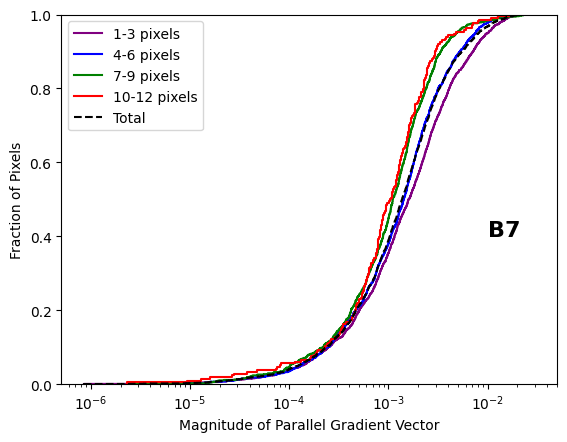

In [13]:
vec_mag_low = []
vec_mag_med = []
vec_mag_high = []
vec_mag_higher = []
total_vec_mag = []

for i in range(lon_length):
    for j in range(lat_length):
        if 1 <= subregion_spines[j][i] <= 3:
            if divergence[j][i] < 0.2:
                #dist_spine_8.append(subregion_spines[j][i])
                vec_mag_low.append(divergence[j][i])
                total_vec_mag.append(divergence[j][i])
        elif 4 <= subregion_spines[j][i] <= 6:
            if divergence[j][i] < 0.2:
                #dist_spine_7.append(subregion_spines[j][i])
                vec_mag_med.append(divergence[j][i])
                total_vec_mag.append(divergence[j][i])
        elif 7 <= subregion_spines[j][i] <= 9:
            if divergence[j][i] < 0.2:
                #dist_spine_6.append(subregion_spines[j][i])
                vec_mag_high.append(divergence[j][i])
                total_vec_mag.append(divergence[j][i])
        elif 10 <= subregion_spines[j][i] <= 12:
            if divergence[j][i] < 0.2:
                #dist_spine_5.append(subregion_spines[j][i])
                vec_mag_higher.append(divergence[j][i])
                total_vec_mag.append(divergence[j][i])

plt.ecdf(vec_mag_low, label = '1-3 pixels', color = 'purple')
plt.ecdf(vec_mag_med, label = '4-6 pixels', color = 'blue')
plt.ecdf(vec_mag_high, label = '7-9 pixels', color = 'green')
plt.ecdf(vec_mag_higher, label = '10-12 pixels', color = 'red')
plt.ecdf(total_vec_mag, label = 'Total', linestyle = 'dashed', color = 'black')

plt.xscale('log')
#plt.xlim(0.003, 0.25)
#plt.ylim(-0.05, 1.05)
plt.text(0.01, 0.4, region, fontsize = 16, fontweight = 'bold')

plt.legend(loc = 'upper left')
plt.xlabel('Magnitude of Parallel Gradient Vector')
plt.ylabel('Fraction of Pixels')